# Instalacja bibliotek

In [1]:
# !pip install tensorflow==2.10.0 tensorflow-io==0.27.0 segmentation_models

# Importy

In [2]:
from PIL import Image
import numpy as np
import pandas as pd
import os
import cv2
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from skimage import filters, restoration
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["SM_FRAMEWORK"] = "tf.keras"

import segmentation_models as sm
import matplotlib.pyplot as plt 
import tensorflow_io as tfio
import tensorflow as tf

from tensorflow import keras 

Segmentation Models: using `tf.keras` framework.


# Przygotowanie danych treningowych

Przygotowanie ścieżek do plików treningowych

In [3]:
train = 'train'
input_data = os.path.join('edited2', train, 'images')
images = sorted(
    [
        os.path.join(input_data, fname)
        for fname in os.listdir(input_data)
    ]
)
input_data = os.path.join(train, 'manual1')
manual = sorted(
    [
        os.path.join(input_data, fname)
        for fname in os.listdir(input_data)
    ]
)

Ustawienie parametrów

In [4]:
image_size = 512
batch_size = 12

Funkcja do odczytywania i przygotowania zdjęcia wejściowego

In [7]:
def read_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(image)
    image = tf.image.grayscale_to_rgb(image)
    image.set_shape([None, None, 3])
    image = tf.image.resize(images=image, size=[image_size, image_size])
    image = image / 255.
    return image

Funkcja do odczytywania i przygotowania obrazu eksperckiego

In [8]:
def read_manual(image_path):
    image = tf.io.read_file(image_path)
    image = tfio.experimental.image.decode_tiff(image)
    image = image[:,:,:3]
    image = tf.image.rgb_to_grayscale(image)
    image = tf.divide(image, 128)
    image.set_shape([None, None, 1])
    image = tf.image.resize(images=image, size=[image_size, image_size])
    image = tf.cast(image, tf.int32)
    return image

Funkcja odczytująca i przygotowująca dane

In [9]:
def load_data(image_list, manual_list):
    image = read_image(image_list)
    manual  = read_manual(manual_list)
    return image, manual

Funkcja do przygotowania zbioru danych testowych

In [10]:
def data_generator(image_list, manual_list):
    dataset = tf.data.Dataset.from_tensor_slices((image_list, manual_list))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    return dataset

Przygotowanie zbioru danych testowych

In [11]:
train_dataset = data_generator(images, manual)
train_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 512, 512, 1), dtype=tf.int32, name=None))>

# Stworzenie i wytrenowanie modelu decyzyjnego

Wyczyszczenie stanu wcześniej zdefiniowanych modeli. Zwolnienie pamięci RAM

In [12]:
keras.backend.clear_session()

Definiowanie parametrów modelu i utworzenie go

In [13]:
BACKBONE   = 'efficientnetb0' # glowny czlon sieci (efficientnetb0 oznacza model na bazie architektury EfficientNetB0)
n_classes  = 1 # liczba klas, które model ma przewidywać (1 oznacza binarna segmentacje obrazu)
activation = 'sigmoid' # funkcja aktywacji (sigmoid jest typowe dla binarnej segmentacji)
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation) # utworzenie modelu ze zdefiniowanymi wczesniej parametrami

Wyświetlenie podsumowania modelu

In [14]:
model.summary(line_length=110)

Model: "model"
______________________________________________________________________________________________________________
 Layer (type)                       Output Shape            Param #      Connected to                         
 input_1 (InputLayer)               [(None, None, None, 3)  0            []                                   
                                    ]                                                                         
                                                                                                              
 stem_conv (Conv2D)                 (None, None, None, 32)  864          ['input_1[0][0]']                    
                                                                                                              
 stem_bn (BatchNormalization)       (None, None, None, 32)  128          ['stem_conv[0][0]']                  
                                                                                                 

                                                                                                              
 block2b_dwconv (DepthwiseConv2D)   (None, None, None, 144  1296         ['block2b_expand_activation[0][0]']  
                                    )                                                                         
                                                                                                              
 block2b_bn (BatchNormalization)    (None, None, None, 144  576          ['block2b_dwconv[0][0]']             
                                    )                                                                         
                                                                                                              
 block2b_activation (Activation)    (None, None, None, 144  0            ['block2b_bn[0][0]']                 
                                    )                                                                         
 

 ion)                               )                                                                         
                                                                                                              
 block3b_dwconv (DepthwiseConv2D)   (None, None, None, 240  6000         ['block3b_expand_activation[0][0]']  
                                    )                                                                         
                                                                                                              
 block3b_bn (BatchNormalization)    (None, None, None, 240  960          ['block3b_dwconv[0][0]']             
                                    )                                                                         
                                                                                                              
 block3b_activation (Activation)    (None, None, None, 240  0            ['block3b_bn[0][0]']                 
 

 block4b_expand_activation (Activat  (None, None, None, 480  0           ['block4b_expand_bn[0][0]']          
 ion)                               )                                                                         
                                                                                                              
 block4b_dwconv (DepthwiseConv2D)   (None, None, None, 480  4320         ['block4b_expand_activation[0][0]']  
                                    )                                                                         
                                                                                                              
 block4b_bn (BatchNormalization)    (None, None, None, 480  1920         ['block4b_dwconv[0][0]']             
                                    )                                                                         
                                                                                                              
 

 block5a_expand_conv (Conv2D)       (None, None, None, 480  38400        ['block4c_add[0][0]']                
                                    )                                                                         
                                                                                                              
 block5a_expand_bn (BatchNormalizat  (None, None, None, 480  1920        ['block5a_expand_conv[0][0]']        
 ion)                               )                                                                         
                                                                                                              
 block5a_expand_activation (Activat  (None, None, None, 480  0           ['block5a_expand_bn[0][0]']          
 ion)                               )                                                                         
                                                                                                              
 

                                                                                                              
 block5b_add (Add)                  (None, None, None, 112  0            ['block5b_drop[0][0]',               
                                    )                                     'block5a_project_bn[0][0]']         
                                                                                                              
 block5c_expand_conv (Conv2D)       (None, None, None, 672  75264        ['block5b_add[0][0]']                
                                    )                                                                         
                                                                                                              
 block5c_expand_bn (BatchNormalizat  (None, None, None, 672  2688        ['block5c_expand_conv[0][0]']        
 ion)                               )                                                                         
 

                                    )                                     'block6a_se_expand[0][0]']          
                                                                                                              
 block6a_project_conv (Conv2D)      (None, None, None, 192  129024       ['block6a_se_excite[0][0]']          
                                    )                                                                         
                                                                                                              
 block6a_project_bn (BatchNormaliza  (None, None, None, 192  768         ['block6a_project_conv[0][0]']       
 tion)                              )                                                                         
                                                                                                              
 block6b_expand_conv (Conv2D)       (None, None, None, 115  221184       ['block6a_project_bn[0][0]']         
 

                                                                                                              
 block6c_se_expand (Conv2D)         (None, 1, 1, 1152)      56448        ['block6c_se_reduce[0][0]']          
                                                                                                              
 block6c_se_excite (Multiply)       (None, None, None, 115  0            ['block6c_activation[0][0]',         
                                    2)                                    'block6c_se_expand[0][0]']          
                                                                                                              
 block6c_project_conv (Conv2D)      (None, None, None, 192  221184       ['block6c_se_excite[0][0]']          
                                    )                                                                         
                                                                                                              
 

                                                                                                              
 block7a_activation (Activation)    (None, None, None, 115  0            ['block7a_bn[0][0]']                 
                                    2)                                                                        
                                                                                                              
 block7a_se_squeeze (GlobalAverageP  (None, 1152)           0            ['block7a_activation[0][0]']         
 ooling2D)                                                                                                    
                                                                                                              
 block7a_se_reshape (Reshape)       (None, 1, 1, 1152)      0            ['block7a_se_squeeze[0][0]']         
                                                                                                              
 

 tion)                              )                                                                         
                                                                                                              
 decoder_stage1b_relu (Activation)  (None, None, None, 128  0            ['decoder_stage1b_bn[0][0]']         
                                    )                                                                         
                                                                                                              
 decoder_stage2_upsampling (UpSampl  (None, None, None, 128  0           ['decoder_stage1b_relu[0][0]']       
 ing2D)                             )                                                                         
                                                                                                              
 decoder_stage2_concat (Concatenate  (None, None, None, 272  0           ['decoder_stage2_upsampling[0][0]',  
 

Stworzenie klasy wykorzystywanej do wyświetlenia niestandardowego callbacku

In [15]:
class DisplayCallback(keras.callbacks.Callback):
    def __init__(self, dataset, epoch_interval=5):
        self.dataset = dataset
        self.epoch_interval = epoch_interval
    
    def display(self, display_list, extra_title=''):
        plt.figure(figsize=(15, 15))
        title = ['Input Image', 'True Mask', 'Predicted Mask']

        if len(display_list) > len(title):
            title.append(extra_title)

        for i in range(len(display_list)):
            plt.subplot(1, len(display_list), i+1)
            plt.title(title[i])
            plt.imshow(display_list[i], cmap='gray')
            plt.axis('off')
        plt.show()
        
    def create_mask(self, pred_mask):
        pred_mask = (pred_mask > 0.5).astype("int32")
        return pred_mask[0]
    
    def show_predictions(self, dataset, num=1):
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            self.display([image[0], mask[0], self.create_mask(pred_mask)])
        
    def on_epoch_end(self, epoch, logs=None):
        if epoch and epoch % self.epoch_interval == 0:
            self.show_predictions(self.dataset)
            print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

Tworzenie obiektu optymalizatora

In [16]:
optimizer = keras.optimizers.Adam(0.0001)

Tworzenie obiektu funkcji straty

In [17]:
losses = keras.losses.BinaryCrossentropy()

Definiowanie listy metryk

In [18]:
metrics = [sm.metrics.Recall(), 'accuracy']

Kompilowanie modelu

In [19]:
model.compile(optimizer, losses, metrics)

Trenowanie modelu

Epoch 1/200
3/3 [==============================] - 90s 25s/step - loss: 0.5842 - recall: 0.3983 - accuracy: 0.7238
Epoch 2/200
3/3 [==============================] - 75s 24s/step - loss: 0.5528 - recall: 0.4509 - accuracy: 0.7541
Epoch 3/200
3/3 [==============================] - 83s 26s/step - loss: 0.5280 - recall: 0.4956 - accuracy: 0.7805
Epoch 4/200
3/3 [==============================] - 82s 26s/step - loss: 0.5077 - recall: 0.5312 - accuracy: 0.8029
Epoch 5/200
3/3 [==============================] - 80s 25s/step - loss: 0.4903 - recall: 0.5601 - accuracy: 0.8221
Epoch 6/200
1/1 [==============================] - 6s 6s/steploss: 0.4752 - recall: 0.5839 - accuracy: 0.838


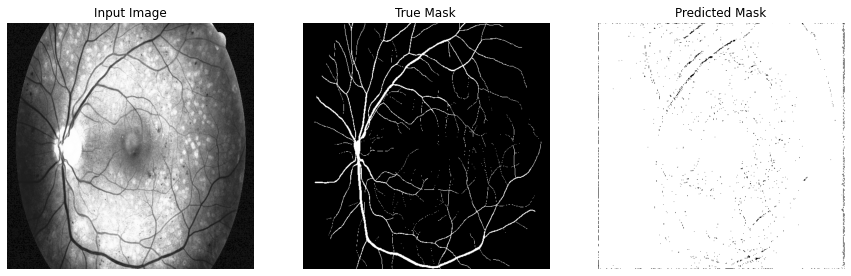


Sample Prediction after epoch 6

3/3 [==============================] - 88s 30s/step - loss: 0.4752 - recall: 0.5839 - accuracy: 0.8387
Epoch 7/200
3/3 [==============================] - 87s 29s/step - loss: 0.4615 - recall: 0.6037 - accuracy: 0.8530
Epoch 8/200
3/3 [==============================] - 89s 26s/step - loss: 0.4490 - recall: 0.6202 - accuracy: 0.8657
Epoch 9/200
3/3 [==============================] - 91s 30s/step - loss: 0.4371 - recall: 0.6348 - accuracy: 0.8771
Epoch 10/200
3/3 [==============================] - 82s 24s/step - loss: 0.4259 - recall: 0.6475 - accuracy: 0.8870
Epoch 11/200
1/1 [==============================] - 4s 4s/steploss: 0.4152 - recall: 0.6584 - accuracy: 0.895


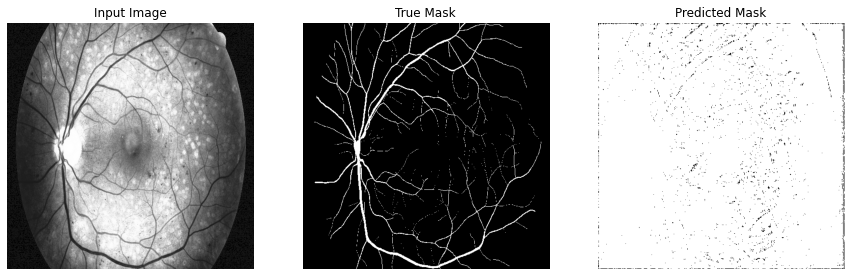


Sample Prediction after epoch 11

3/3 [==============================] - 85s 29s/step - loss: 0.4152 - recall: 0.6584 - accuracy: 0.8959
Epoch 12/200
3/3 [==============================] - 77s 24s/step - loss: 0.4048 - recall: 0.6682 - accuracy: 0.9039
Epoch 13/200
3/3 [==============================] - 77s 24s/step - loss: 0.3948 - recall: 0.6766 - accuracy: 0.9108
Epoch 14/200
3/3 [==============================] - 77s 24s/step - loss: 0.3847 - recall: 0.6845 - accuracy: 0.9171
Epoch 15/200
3/3 [==============================] - 77s 24s/step - loss: 0.3748 - recall: 0.6906 - accuracy: 0.9225
Epoch 16/200
1/1 [==============================] - 5s 5s/steploss: 0.3652 - recall: 0.6951 - accuracy: 0.927


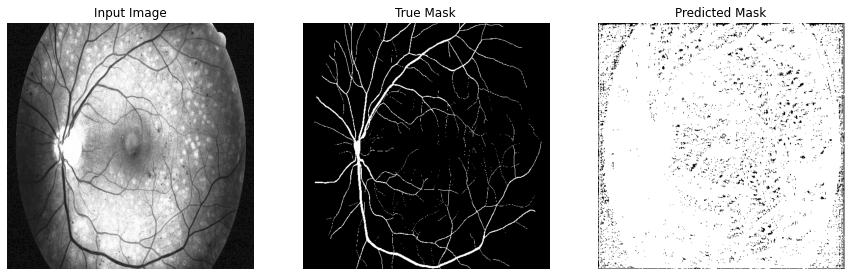


Sample Prediction after epoch 16

3/3 [==============================] - 84s 28s/step - loss: 0.3652 - recall: 0.6951 - accuracy: 0.9273
Epoch 17/200
3/3 [==============================] - 77s 24s/step - loss: 0.3558 - recall: 0.6983 - accuracy: 0.9313
Epoch 18/200
3/3 [==============================] - 76s 24s/step - loss: 0.3468 - recall: 0.7016 - accuracy: 0.9349
Epoch 19/200
3/3 [==============================] - 76s 24s/step - loss: 0.3384 - recall: 0.7022 - accuracy: 0.9381
Epoch 20/200
3/3 [==============================] - 78s 25s/step - loss: 0.3301 - recall: 0.7039 - accuracy: 0.9408
Epoch 21/200
1/1 [==============================] - 6s 6s/steploss: 0.3221 - recall: 0.7040 - accuracy: 0.943


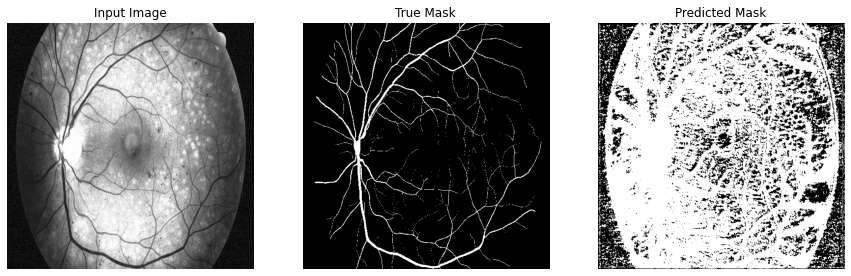


Sample Prediction after epoch 21

3/3 [==============================] - 86s 28s/step - loss: 0.3221 - recall: 0.7040 - accuracy: 0.9433
Epoch 22/200
3/3 [==============================] - 76s 24s/step - loss: 0.3145 - recall: 0.7035 - accuracy: 0.9455
Epoch 23/200
3/3 [==============================] - 77s 24s/step - loss: 0.3070 - recall: 0.7036 - accuracy: 0.9474
Epoch 24/200
3/3 [==============================] - 77s 24s/step - loss: 0.3000 - recall: 0.7026 - accuracy: 0.9492
Epoch 25/200
3/3 [==============================] - 77s 24s/step - loss: 0.2935 - recall: 0.7018 - accuracy: 0.9505
Epoch 26/200
1/1 [==============================] - 6s 6s/steploss: 0.2870 - recall: 0.7016 - accuracy: 0.951


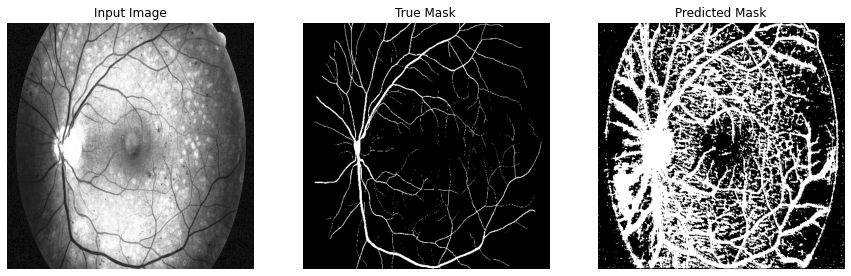


Sample Prediction after epoch 26

3/3 [==============================] - 94s 32s/step - loss: 0.2870 - recall: 0.7016 - accuracy: 0.9519
Epoch 27/200
3/3 [==============================] - 86s 28s/step - loss: 0.2811 - recall: 0.6997 - accuracy: 0.9530
Epoch 28/200
3/3 [==============================] - 90s 28s/step - loss: 0.2754 - recall: 0.6988 - accuracy: 0.9541
Epoch 29/200
3/3 [==============================] - 82s 25s/step - loss: 0.2700 - recall: 0.6963 - accuracy: 0.9550
Epoch 30/200
3/3 [==============================] - 94s 33s/step - loss: 0.2648 - recall: 0.6961 - accuracy: 0.9560
Epoch 31/200
1/1 [==============================] - 6s 6s/steploss: 0.2601 - recall: 0.6944 - accuracy: 0.956


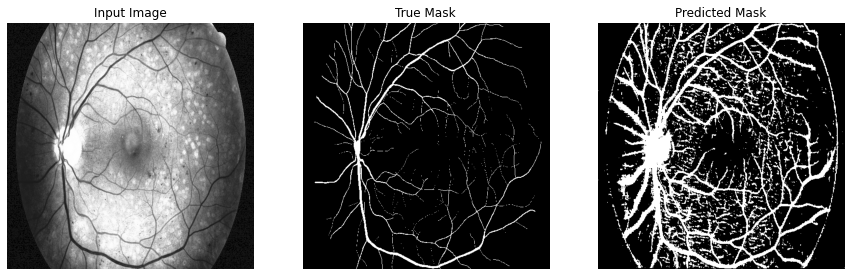


Sample Prediction after epoch 31

3/3 [==============================] - 95s 32s/step - loss: 0.2601 - recall: 0.6944 - accuracy: 0.9565
Epoch 32/200
3/3 [==============================] - 84s 27s/step - loss: 0.2553 - recall: 0.6928 - accuracy: 0.9573
Epoch 33/200
3/3 [==============================] - 101s 31s/step - loss: 0.2507 - recall: 0.6932 - accuracy: 0.9579
Epoch 34/200
3/3 [==============================] - 103s 34s/step - loss: 0.2464 - recall: 0.6911 - accuracy: 0.9585
Epoch 35/200
3/3 [==============================] - 95s 30s/step - loss: 0.2421 - recall: 0.6904 - accuracy: 0.9591
Epoch 36/200
1/1 [==============================] - 6s 6s/steploss: 0.2382 - recall: 0.6902 - accuracy: 0.959


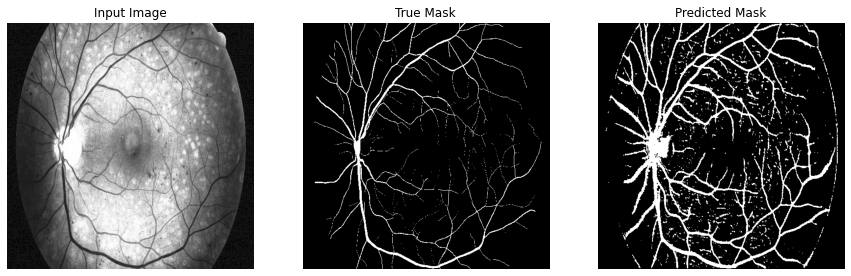


Sample Prediction after epoch 36

3/3 [==============================] - 90s 30s/step - loss: 0.2382 - recall: 0.6902 - accuracy: 0.9595
Epoch 37/200
3/3 [==============================] - 99s 34s/step - loss: 0.2346 - recall: 0.6890 - accuracy: 0.9598
Epoch 38/200
3/3 [==============================] - 103s 32s/step - loss: 0.2310 - recall: 0.6862 - accuracy: 0.9602
Epoch 39/200
3/3 [==============================] - 95s 30s/step - loss: 0.2275 - recall: 0.6870 - accuracy: 0.9606
Epoch 40/200
3/3 [==============================] - 101s 32s/step - loss: 0.2241 - recall: 0.6871 - accuracy: 0.9609
Epoch 41/200
1/1 [==============================] - 7s 7s/steploss: 0.2207 - recall: 0.6848 - accuracy: 0.961


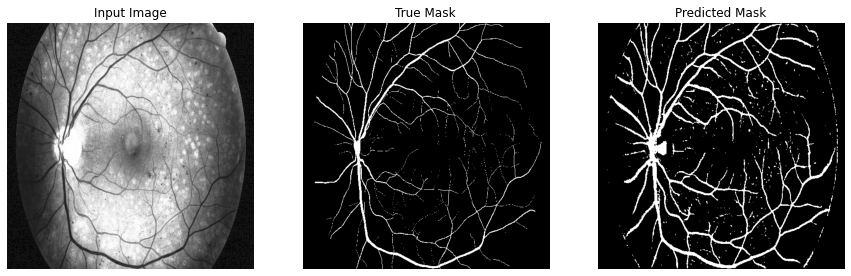


Sample Prediction after epoch 41

3/3 [==============================] - 105s 35s/step - loss: 0.2207 - recall: 0.6848 - accuracy: 0.9614
Epoch 42/200
3/3 [==============================] - 89s 26s/step - loss: 0.2176 - recall: 0.6860 - accuracy: 0.9617
Epoch 43/200
3/3 [==============================] - 88s 28s/step - loss: 0.2146 - recall: 0.6848 - accuracy: 0.9620
Epoch 44/200
3/3 [==============================] - 88s 28s/step - loss: 0.2119 - recall: 0.6852 - accuracy: 0.9622
Epoch 45/200
3/3 [==============================] - 102s 32s/step - loss: 0.2091 - recall: 0.6851 - accuracy: 0.9625
Epoch 46/200
1/1 [==============================] - 7s 7s/steploss: 0.2066 - recall: 0.6837 - accuracy: 0.962


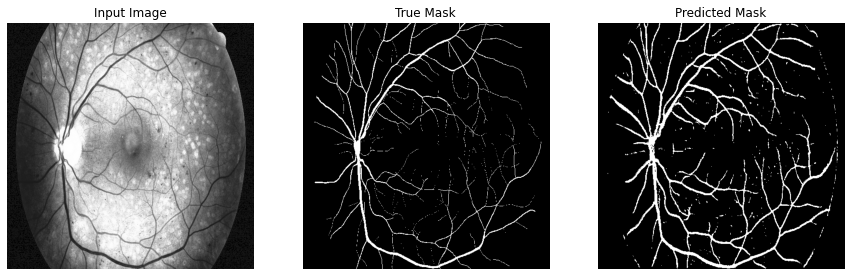


Sample Prediction after epoch 46

3/3 [==============================] - 116s 39s/step - loss: 0.2066 - recall: 0.6837 - accuracy: 0.9627
Epoch 47/200
3/3 [==============================] - 108s 35s/step - loss: 0.2038 - recall: 0.6842 - accuracy: 0.9631
Epoch 48/200
3/3 [==============================] - 109s 35s/step - loss: 0.2015 - recall: 0.6832 - accuracy: 0.9632
Epoch 49/200
3/3 [==============================] - 101s 32s/step - loss: 0.1990 - recall: 0.6835 - accuracy: 0.9635
Epoch 50/200
3/3 [==============================] - 90s 30s/step - loss: 0.1967 - recall: 0.6842 - accuracy: 0.9637
Epoch 51/200
1/1 [==============================] - 6s 6s/steploss: 0.1946 - recall: 0.6836 - accuracy: 0.963


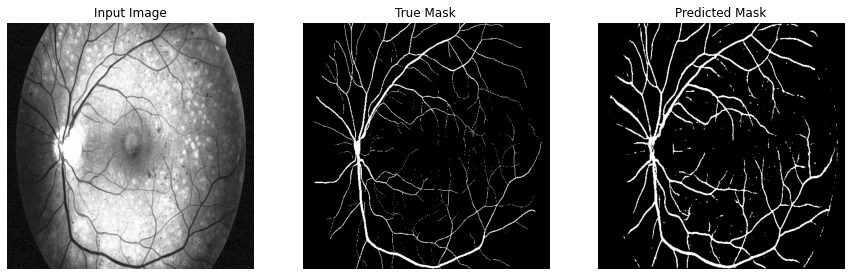


Sample Prediction after epoch 51

3/3 [==============================] - 99s 34s/step - loss: 0.1946 - recall: 0.6836 - accuracy: 0.9639
Epoch 52/200
3/3 [==============================] - 104s 33s/step - loss: 0.1922 - recall: 0.6839 - accuracy: 0.9642
Epoch 53/200
3/3 [==============================] - 96s 31s/step - loss: 0.1901 - recall: 0.6852 - accuracy: 0.9643
Epoch 54/200
3/3 [==============================] - 96s 31s/step - loss: 0.1879 - recall: 0.6835 - accuracy: 0.9647
Epoch 55/200
3/3 [==============================] - 102s 32s/step - loss: 0.1859 - recall: 0.6846 - accuracy: 0.9648
Epoch 56/200
1/1 [==============================] - 6s 6s/steploss: 0.1841 - recall: 0.6841 - accuracy: 0.965


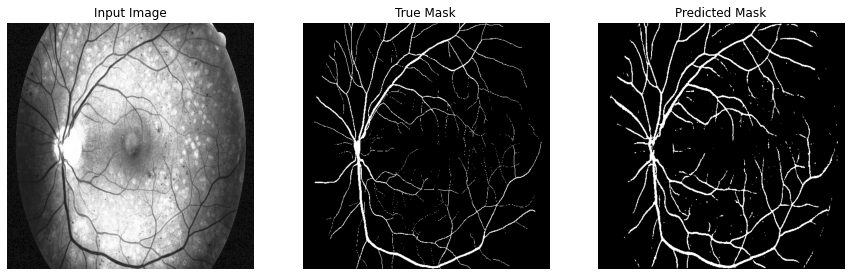


Sample Prediction after epoch 56

3/3 [==============================] - 102s 33s/step - loss: 0.1841 - recall: 0.6841 - accuracy: 0.9650
Epoch 57/200
3/3 [==============================] - 101s 30s/step - loss: 0.1820 - recall: 0.6842 - accuracy: 0.9653
Epoch 58/200
3/3 [==============================] - 92s 29s/step - loss: 0.1803 - recall: 0.6847 - accuracy: 0.9654
Epoch 59/200
3/3 [==============================] - 92s 29s/step - loss: 0.1787 - recall: 0.6839 - accuracy: 0.9655
Epoch 60/200
3/3 [==============================] - 99s 32s/step - loss: 0.1768 - recall: 0.6852 - accuracy: 0.9658
Epoch 61/200
1/1 [==============================] - 6s 6s/steploss: 0.1753 - recall: 0.6859 - accuracy: 0.965


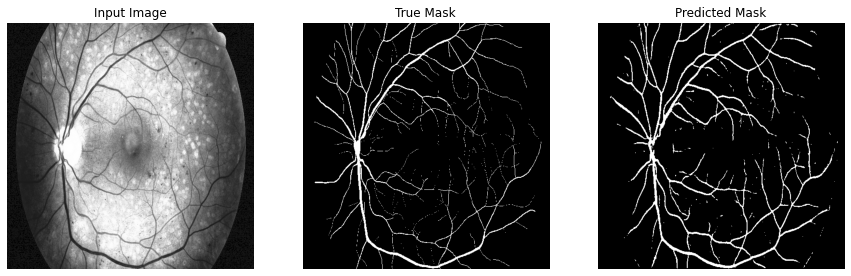


Sample Prediction after epoch 61

3/3 [==============================] - 105s 33s/step - loss: 0.1753 - recall: 0.6859 - accuracy: 0.9659
Epoch 62/200
3/3 [==============================] - 83s 27s/step - loss: 0.1735 - recall: 0.6860 - accuracy: 0.9662
Epoch 63/200
3/3 [==============================] - 86s 29s/step - loss: 0.1721 - recall: 0.6864 - accuracy: 0.9663
Epoch 64/200
3/3 [==============================] - 87s 28s/step - loss: 0.1706 - recall: 0.6866 - accuracy: 0.9664
Epoch 65/200
3/3 [==============================] - 82s 26s/step - loss: 0.1691 - recall: 0.6873 - accuracy: 0.9666
Epoch 66/200
1/1 [==============================] - 7s 7s/steploss: 0.1680 - recall: 0.6858 - accuracy: 0.966


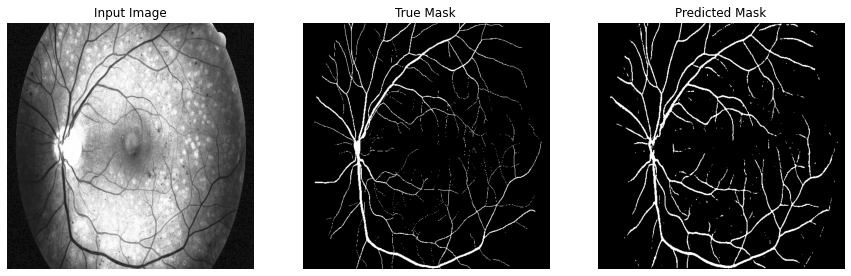


Sample Prediction after epoch 66

3/3 [==============================] - 104s 37s/step - loss: 0.1680 - recall: 0.6858 - accuracy: 0.9665
Epoch 67/200
3/3 [==============================] - 94s 30s/step - loss: 0.1665 - recall: 0.6873 - accuracy: 0.9668
Epoch 68/200
3/3 [==============================] - 93s 30s/step - loss: 0.1650 - recall: 0.6879 - accuracy: 0.9670
Epoch 69/200
3/3 [==============================] - 92s 29s/step - loss: 0.1634 - recall: 0.6890 - accuracy: 0.9672
Epoch 70/200
3/3 [==============================] - 92s 29s/step - loss: 0.1622 - recall: 0.6897 - accuracy: 0.9674
Epoch 71/200
1/1 [==============================] - 6s 6s/steploss: 0.1607 - recall: 0.6902 - accuracy: 0.967


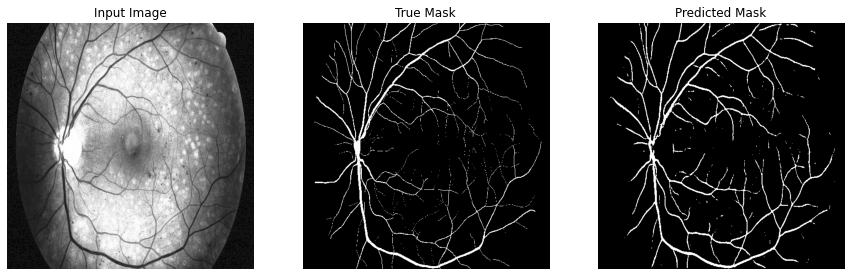


Sample Prediction after epoch 71

3/3 [==============================] - 84s 27s/step - loss: 0.1607 - recall: 0.6902 - accuracy: 0.9676
Epoch 72/200
3/3 [==============================] - 76s 23s/step - loss: 0.1595 - recall: 0.6907 - accuracy: 0.9677
Epoch 73/200
3/3 [==============================] - 76s 24s/step - loss: 0.1583 - recall: 0.6913 - accuracy: 0.9678
Epoch 74/200
3/3 [==============================] - 75s 24s/step - loss: 0.1571 - recall: 0.6919 - accuracy: 0.9678
Epoch 75/200
3/3 [==============================] - 75s 23s/step - loss: 0.1561 - recall: 0.6907 - accuracy: 0.9679
Epoch 76/200
1/1 [==============================] - 5s 5s/steploss: 0.1550 - recall: 0.6924 - accuracy: 0.967


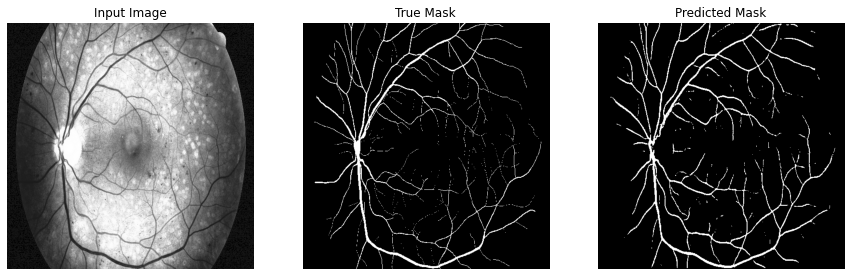


Sample Prediction after epoch 76

3/3 [==============================] - 84s 28s/step - loss: 0.1550 - recall: 0.6924 - accuracy: 0.9679
Epoch 77/200
3/3 [==============================] - 69s 21s/step - loss: 0.1536 - recall: 0.6936 - accuracy: 0.9682
Epoch 78/200
3/3 [==============================] - 77s 26s/step - loss: 0.1520 - recall: 0.6937 - accuracy: 0.9686
Epoch 79/200
3/3 [==============================] - 80s 26s/step - loss: 0.1511 - recall: 0.6950 - accuracy: 0.9686
Epoch 80/200
3/3 [==============================] - 88s 25s/step - loss: 0.1504 - recall: 0.6950 - accuracy: 0.9685
Epoch 81/200
1/1 [==============================] - 6s 6s/steploss: 0.1489 - recall: 0.6948 - accuracy: 0.968


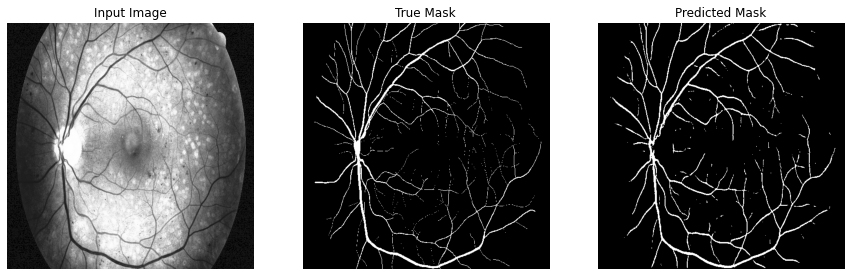


Sample Prediction after epoch 81

3/3 [==============================] - 94s 31s/step - loss: 0.1489 - recall: 0.6948 - accuracy: 0.9689
Epoch 82/200
3/3 [==============================] - 90s 29s/step - loss: 0.1480 - recall: 0.6969 - accuracy: 0.9689
Epoch 83/200
3/3 [==============================] - 79s 25s/step - loss: 0.1469 - recall: 0.6963 - accuracy: 0.9691
Epoch 84/200
3/3 [==============================] - 77s 24s/step - loss: 0.1460 - recall: 0.6969 - accuracy: 0.9690
Epoch 85/200
3/3 [==============================] - 82s 26s/step - loss: 0.1448 - recall: 0.6981 - accuracy: 0.9693
Epoch 86/200
1/1 [==============================] - 5s 5s/steploss: 0.1438 - recall: 0.6982 - accuracy: 0.969


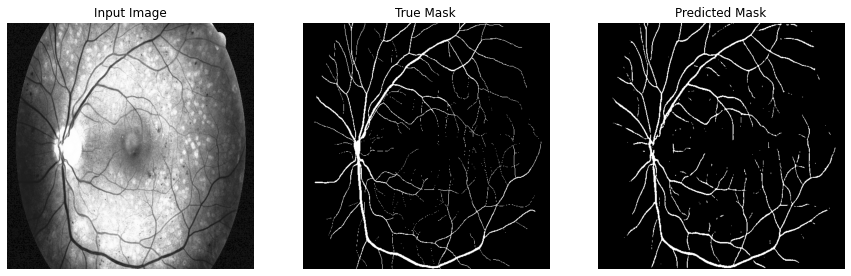


Sample Prediction after epoch 86

3/3 [==============================] - 89s 29s/step - loss: 0.1438 - recall: 0.6982 - accuracy: 0.9694
Epoch 87/200
3/3 [==============================] - 83s 27s/step - loss: 0.1427 - recall: 0.6992 - accuracy: 0.9696
Epoch 88/200
3/3 [==============================] - 88s 28s/step - loss: 0.1415 - recall: 0.7008 - accuracy: 0.9698
Epoch 89/200
3/3 [==============================] - 79s 25s/step - loss: 0.1408 - recall: 0.6997 - accuracy: 0.9698
Epoch 90/200
3/3 [==============================] - 86s 27s/step - loss: 0.1397 - recall: 0.7017 - accuracy: 0.9700
Epoch 91/200
1/1 [==============================] - 6s 6s/steploss: 0.1392 - recall: 0.7010 - accuracy: 0.969


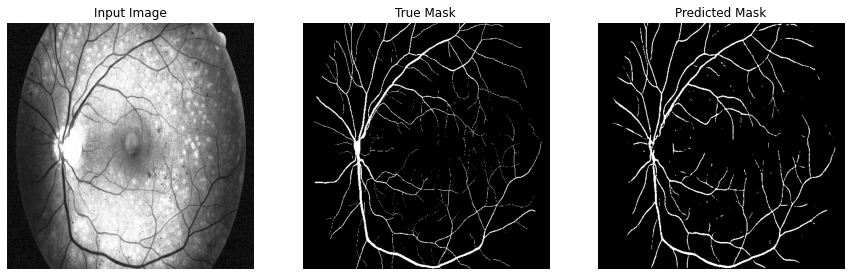


Sample Prediction after epoch 91

3/3 [==============================] - 93s 31s/step - loss: 0.1392 - recall: 0.7010 - accuracy: 0.9698
Epoch 92/200
3/3 [==============================] - 80s 26s/step - loss: 0.1377 - recall: 0.7026 - accuracy: 0.9703
Epoch 93/200
3/3 [==============================] - 77s 24s/step - loss: 0.1370 - recall: 0.7030 - accuracy: 0.9702
Epoch 94/200
3/3 [==============================] - 77s 24s/step - loss: 0.1363 - recall: 0.7029 - accuracy: 0.9702
Epoch 95/200
3/3 [==============================] - 94s 31s/step - loss: 0.1353 - recall: 0.7044 - accuracy: 0.9704
Epoch 96/200
1/1 [==============================] - 6s 6s/steploss: 0.1341 - recall: 0.7053 - accuracy: 0.970


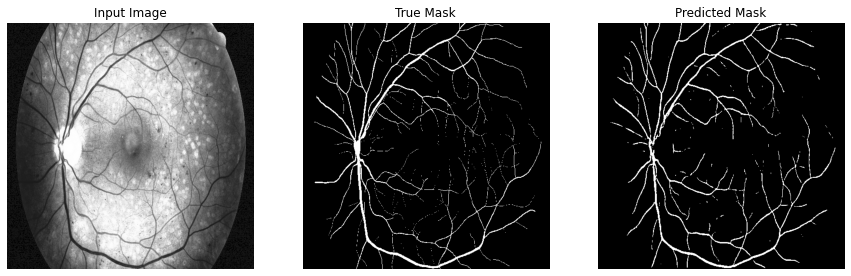


Sample Prediction after epoch 96

3/3 [==============================] - 89s 29s/step - loss: 0.1341 - recall: 0.7053 - accuracy: 0.9708
Epoch 97/200
3/3 [==============================] - 78s 25s/step - loss: 0.1334 - recall: 0.7054 - accuracy: 0.9707
Epoch 98/200
3/3 [==============================] - 83s 26s/step - loss: 0.1326 - recall: 0.7055 - accuracy: 0.9709
Epoch 99/200
3/3 [==============================] - 82s 26s/step - loss: 0.1316 - recall: 0.7075 - accuracy: 0.9711
Epoch 100/200
3/3 [==============================] - 82s 26s/step - loss: 0.1307 - recall: 0.7081 - accuracy: 0.9712
Epoch 101/200
1/1 [==============================] - 5s 5s/steploss: 0.1300 - recall: 0.7084 - accuracy: 0.971


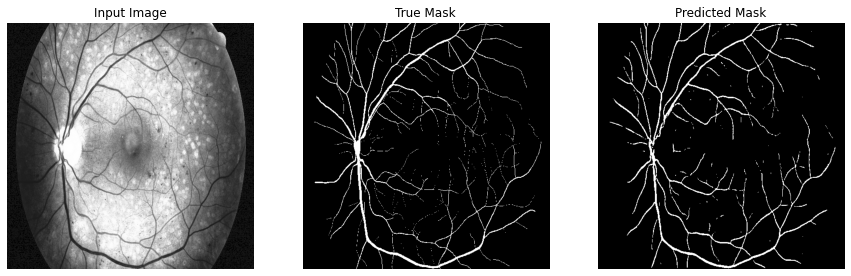


Sample Prediction after epoch 101

3/3 [==============================] - 88s 28s/step - loss: 0.1300 - recall: 0.7084 - accuracy: 0.9712
Epoch 102/200
3/3 [==============================] - 80s 26s/step - loss: 0.1289 - recall: 0.7097 - accuracy: 0.9714
Epoch 103/200
3/3 [==============================] - 79s 25s/step - loss: 0.1282 - recall: 0.7095 - accuracy: 0.9715
Epoch 104/200
3/3 [==============================] - 78s 25s/step - loss: 0.1272 - recall: 0.7108 - accuracy: 0.9717
Epoch 105/200
3/3 [==============================] - 79s 25s/step - loss: 0.1267 - recall: 0.7112 - accuracy: 0.9717
Epoch 106/200
1/1 [==============================] - 6s 6s/steploss: 0.1259 - recall: 0.7114 - accuracy: 0.971


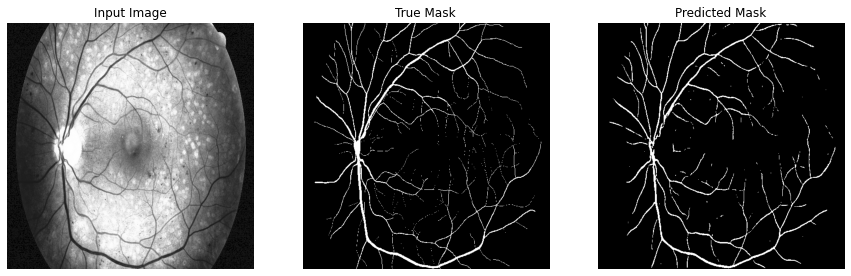


Sample Prediction after epoch 106

3/3 [==============================] - 85s 28s/step - loss: 0.1259 - recall: 0.7114 - accuracy: 0.9718
Epoch 107/200
3/3 [==============================] - 81s 25s/step - loss: 0.1253 - recall: 0.7118 - accuracy: 0.9718
Epoch 108/200
3/3 [==============================] - 79s 25s/step - loss: 0.1245 - recall: 0.7127 - accuracy: 0.9720
Epoch 109/200
3/3 [==============================] - 78s 25s/step - loss: 0.1243 - recall: 0.7118 - accuracy: 0.9717
Epoch 110/200
3/3 [==============================] - 75s 23s/step - loss: 0.1229 - recall: 0.7131 - accuracy: 0.9722
Epoch 111/200
1/1 [==============================] - 6s 6s/steploss: 0.1222 - recall: 0.7151 - accuracy: 0.972


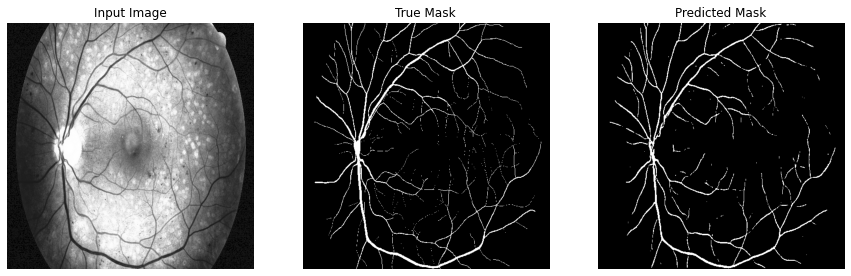


Sample Prediction after epoch 111

3/3 [==============================] - 85s 29s/step - loss: 0.1222 - recall: 0.7151 - accuracy: 0.9723
Epoch 112/200
3/3 [==============================] - 84s 27s/step - loss: 0.1216 - recall: 0.7146 - accuracy: 0.9724
Epoch 113/200
3/3 [==============================] - 80s 26s/step - loss: 0.1206 - recall: 0.7159 - accuracy: 0.9726
Epoch 114/200
3/3 [==============================] - 78s 24s/step - loss: 0.1201 - recall: 0.7169 - accuracy: 0.9726
Epoch 115/200
3/3 [==============================] - 74s 23s/step - loss: 0.1193 - recall: 0.7160 - accuracy: 0.9728
Epoch 116/200
1/1 [==============================] - 6s 6s/steploss: 0.1187 - recall: 0.7179 - accuracy: 0.972


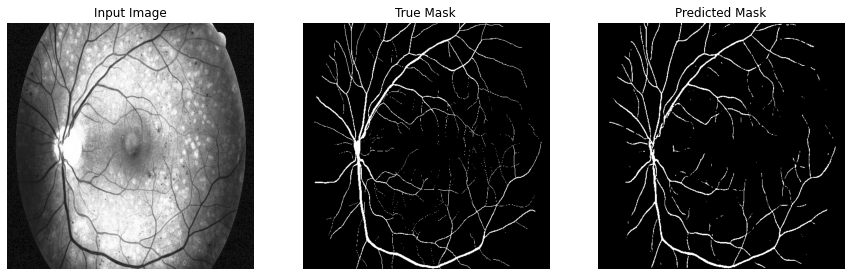


Sample Prediction after epoch 116

3/3 [==============================] - 85s 29s/step - loss: 0.1187 - recall: 0.7179 - accuracy: 0.9728
Epoch 117/200
3/3 [==============================] - 75s 23s/step - loss: 0.1181 - recall: 0.7179 - accuracy: 0.9729
Epoch 118/200
3/3 [==============================] - 77s 23s/step - loss: 0.1174 - recall: 0.7184 - accuracy: 0.9730
Epoch 119/200
3/3 [==============================] - 67s 21s/step - loss: 0.1167 - recall: 0.7185 - accuracy: 0.9731
Epoch 120/200
3/3 [==============================] - 69s 22s/step - loss: 0.1164 - recall: 0.7182 - accuracy: 0.9730
Epoch 121/200
1/1 [==============================] - 5s 5s/steploss: 0.1148 - recall: 0.7224 - accuracy: 0.973


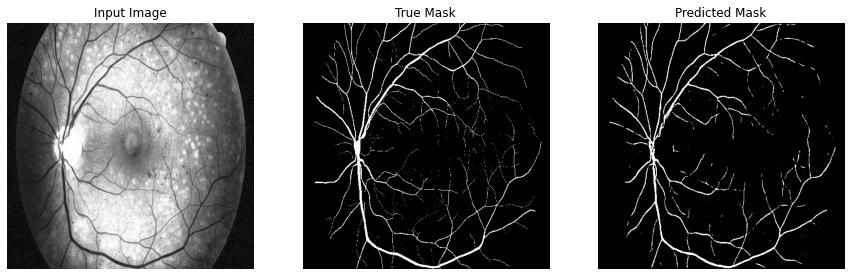


Sample Prediction after epoch 121

3/3 [==============================] - 75s 25s/step - loss: 0.1148 - recall: 0.7224 - accuracy: 0.9737
Epoch 122/200
3/3 [==============================] - 68s 21s/step - loss: 0.1146 - recall: 0.7210 - accuracy: 0.9735
Epoch 123/200
3/3 [==============================] - 67s 21s/step - loss: 0.1140 - recall: 0.7216 - accuracy: 0.9736
Epoch 124/200
3/3 [==============================] - 68s 21s/step - loss: 0.1133 - recall: 0.7226 - accuracy: 0.9737
Epoch 125/200
3/3 [==============================] - 69s 21s/step - loss: 0.1129 - recall: 0.7228 - accuracy: 0.9737
Epoch 126/200
1/1 [==============================] - 5s 5s/steploss: 0.1117 - recall: 0.7241 - accuracy: 0.974


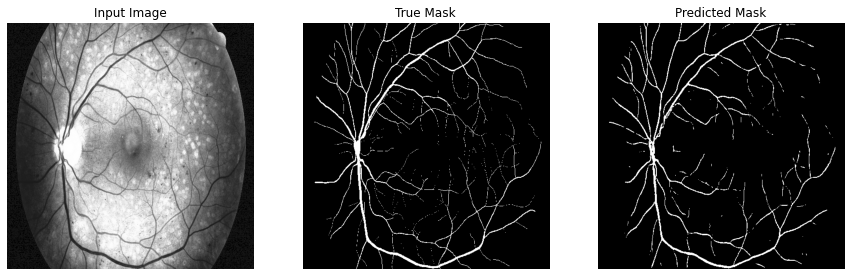


Sample Prediction after epoch 126

3/3 [==============================] - 74s 25s/step - loss: 0.1117 - recall: 0.7241 - accuracy: 0.9742
Epoch 127/200
3/3 [==============================] - 67s 21s/step - loss: 0.1115 - recall: 0.7246 - accuracy: 0.9741
Epoch 128/200
3/3 [==============================] - 67s 21s/step - loss: 0.1108 - recall: 0.7243 - accuracy: 0.9742
Epoch 129/200
3/3 [==============================] - 68s 21s/step - loss: 0.1105 - recall: 0.7245 - accuracy: 0.9741
Epoch 130/200
3/3 [==============================] - 67s 21s/step - loss: 0.1099 - recall: 0.7253 - accuracy: 0.9742
Epoch 131/200
1/1 [==============================] - 5s 5s/steploss: 0.1091 - recall: 0.7261 - accuracy: 0.974


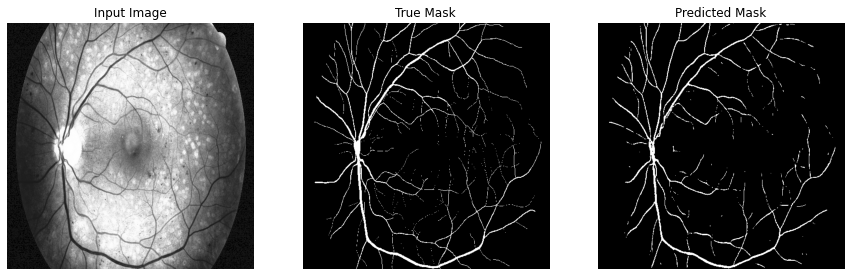


Sample Prediction after epoch 131

3/3 [==============================] - 74s 25s/step - loss: 0.1091 - recall: 0.7261 - accuracy: 0.9744
Epoch 132/200
3/3 [==============================] - 67s 21s/step - loss: 0.1087 - recall: 0.7264 - accuracy: 0.9745
Epoch 133/200
3/3 [==============================] - 70s 22s/step - loss: 0.1080 - recall: 0.7276 - accuracy: 0.9746
Epoch 134/200
3/3 [==============================] - 68s 21s/step - loss: 0.1075 - recall: 0.7278 - accuracy: 0.9747
Epoch 135/200
3/3 [==============================] - 67s 21s/step - loss: 0.1067 - recall: 0.7287 - accuracy: 0.9750
Epoch 136/200
1/1 [==============================] - 5s 5s/steploss: 0.1061 - recall: 0.7294 - accuracy: 0.975


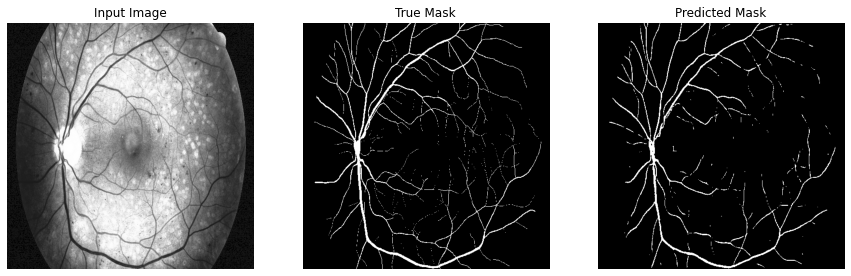


Sample Prediction after epoch 136

3/3 [==============================] - 74s 25s/step - loss: 0.1061 - recall: 0.7294 - accuracy: 0.9751
Epoch 137/200
3/3 [==============================] - 68s 21s/step - loss: 0.1059 - recall: 0.7298 - accuracy: 0.9749
Epoch 138/200
3/3 [==============================] - 68s 21s/step - loss: 0.1050 - recall: 0.7305 - accuracy: 0.9752
Epoch 139/200
3/3 [==============================] - 67s 21s/step - loss: 0.1051 - recall: 0.7290 - accuracy: 0.9750
Epoch 140/200
3/3 [==============================] - 68s 22s/step - loss: 0.1043 - recall: 0.7308 - accuracy: 0.9752
Epoch 141/200
1/1 [==============================] - 5s 5s/steploss: 0.1036 - recall: 0.7321 - accuracy: 0.975


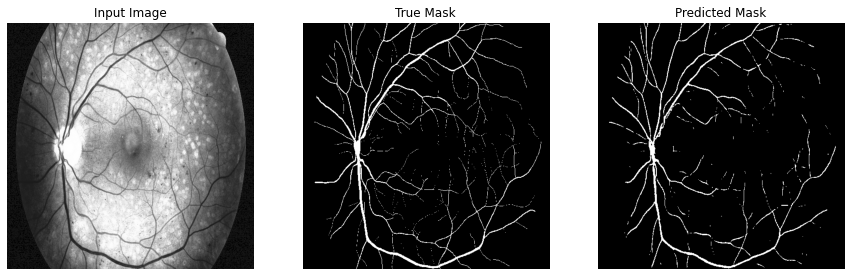


Sample Prediction after epoch 141

3/3 [==============================] - 74s 25s/step - loss: 0.1036 - recall: 0.7321 - accuracy: 0.9754
Epoch 142/200
3/3 [==============================] - 67s 21s/step - loss: 0.1033 - recall: 0.7320 - accuracy: 0.9754
Epoch 143/200
3/3 [==============================] - 67s 21s/step - loss: 0.1025 - recall: 0.7326 - accuracy: 0.9756
Epoch 144/200
3/3 [==============================] - 67s 21s/step - loss: 0.1023 - recall: 0.7326 - accuracy: 0.9755
Epoch 145/200
3/3 [==============================] - 67s 21s/step - loss: 0.1014 - recall: 0.7345 - accuracy: 0.9759
Epoch 146/200
1/1 [==============================] - 5s 5s/steploss: 0.1013 - recall: 0.7340 - accuracy: 0.975


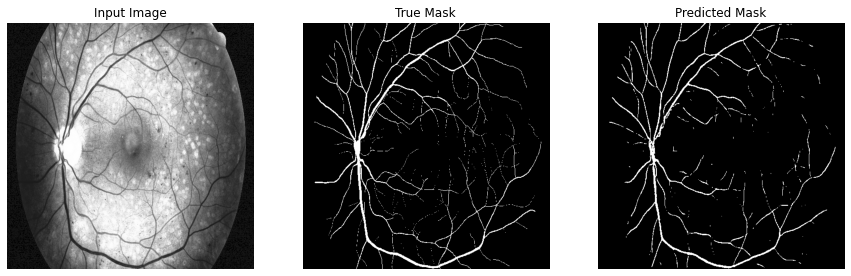


Sample Prediction after epoch 146

3/3 [==============================] - 76s 26s/step - loss: 0.1013 - recall: 0.7340 - accuracy: 0.9757
Epoch 147/200
3/3 [==============================] - 67s 21s/step - loss: 0.1004 - recall: 0.7351 - accuracy: 0.9760
Epoch 148/200
3/3 [==============================] - 67s 21s/step - loss: 0.0999 - recall: 0.7362 - accuracy: 0.9762
Epoch 149/200
3/3 [==============================] - 67s 21s/step - loss: 0.0997 - recall: 0.7357 - accuracy: 0.9760
Epoch 150/200
3/3 [==============================] - 67s 21s/step - loss: 0.0990 - recall: 0.7374 - accuracy: 0.9763
Epoch 151/200
1/1 [==============================] - 5s 5s/steploss: 0.0984 - recall: 0.7370 - accuracy: 0.976


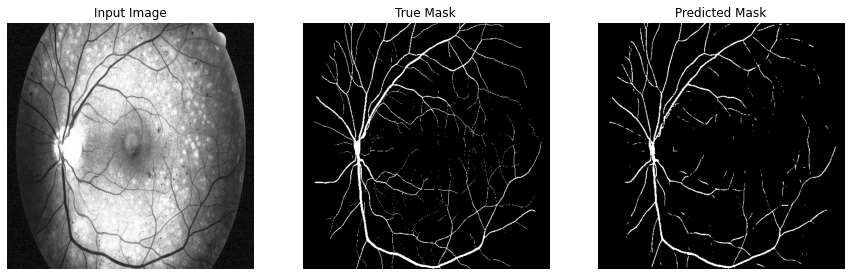


Sample Prediction after epoch 151

3/3 [==============================] - 74s 25s/step - loss: 0.0984 - recall: 0.7370 - accuracy: 0.9764
Epoch 152/200
3/3 [==============================] - 68s 22s/step - loss: 0.0981 - recall: 0.7383 - accuracy: 0.9764
Epoch 153/200
3/3 [==============================] - 68s 21s/step - loss: 0.0977 - recall: 0.7375 - accuracy: 0.9765
Epoch 154/200
3/3 [==============================] - 67s 21s/step - loss: 0.0971 - recall: 0.7387 - accuracy: 0.9767
Epoch 155/200
3/3 [==============================] - 67s 21s/step - loss: 0.0968 - recall: 0.7396 - accuracy: 0.9767
Epoch 156/200
1/1 [==============================] - 5s 5s/steploss: 0.0960 - recall: 0.7400 - accuracy: 0.977


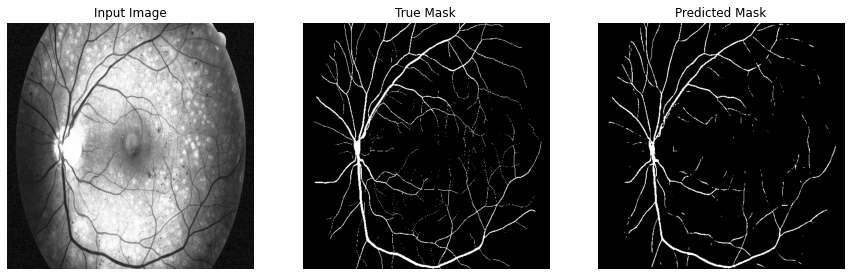


Sample Prediction after epoch 156

3/3 [==============================] - 75s 25s/step - loss: 0.0960 - recall: 0.7400 - accuracy: 0.9770
Epoch 157/200
3/3 [==============================] - 67s 21s/step - loss: 0.0957 - recall: 0.7409 - accuracy: 0.9769
Epoch 158/200
3/3 [==============================] - 67s 21s/step - loss: 0.0953 - recall: 0.7416 - accuracy: 0.9770
Epoch 159/200
3/3 [==============================] - 67s 21s/step - loss: 0.0951 - recall: 0.7406 - accuracy: 0.9769
Epoch 160/200
3/3 [==============================] - 67s 21s/step - loss: 0.0944 - recall: 0.7414 - accuracy: 0.9772
Epoch 161/200
1/1 [==============================] - 5s 5s/steploss: 0.0940 - recall: 0.7438 - accuracy: 0.977


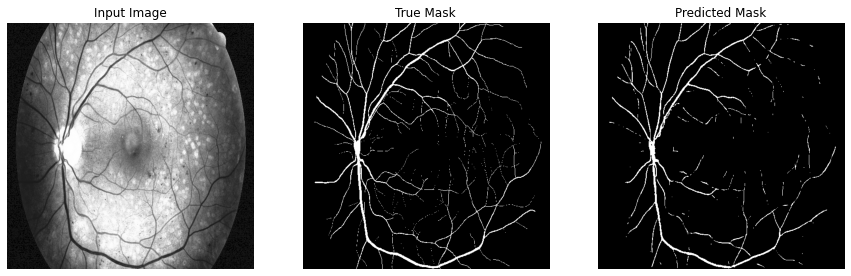


Sample Prediction after epoch 161

3/3 [==============================] - 74s 25s/step - loss: 0.0940 - recall: 0.7438 - accuracy: 0.9773
Epoch 162/200
3/3 [==============================] - 67s 21s/step - loss: 0.0938 - recall: 0.7419 - accuracy: 0.9772
Epoch 163/200
3/3 [==============================] - 68s 22s/step - loss: 0.0931 - recall: 0.7431 - accuracy: 0.9775
Epoch 164/200
3/3 [==============================] - 67s 21s/step - loss: 0.0930 - recall: 0.7437 - accuracy: 0.9773
Epoch 165/200
3/3 [==============================] - 67s 21s/step - loss: 0.0920 - recall: 0.7451 - accuracy: 0.9778
Epoch 166/200
1/1 [==============================] - 5s 5s/steploss: 0.0919 - recall: 0.7455 - accuracy: 0.977


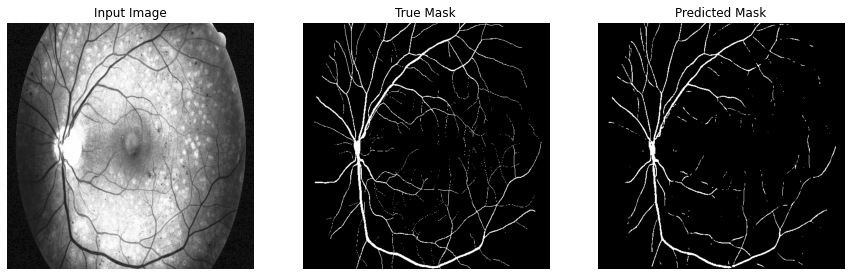


Sample Prediction after epoch 166

3/3 [==============================] - 74s 25s/step - loss: 0.0919 - recall: 0.7455 - accuracy: 0.9777
Epoch 167/200
3/3 [==============================] - 67s 21s/step - loss: 0.0919 - recall: 0.7439 - accuracy: 0.9775
Epoch 168/200
3/3 [==============================] - 67s 21s/step - loss: 0.0913 - recall: 0.7460 - accuracy: 0.9777
Epoch 169/200
3/3 [==============================] - 67s 21s/step - loss: 0.0907 - recall: 0.7461 - accuracy: 0.9779
Epoch 170/200
3/3 [==============================] - 67s 21s/step - loss: 0.0902 - recall: 0.7472 - accuracy: 0.9780
Epoch 171/200
1/1 [==============================] - 5s 5s/steploss: 0.0897 - recall: 0.7479 - accuracy: 0.978


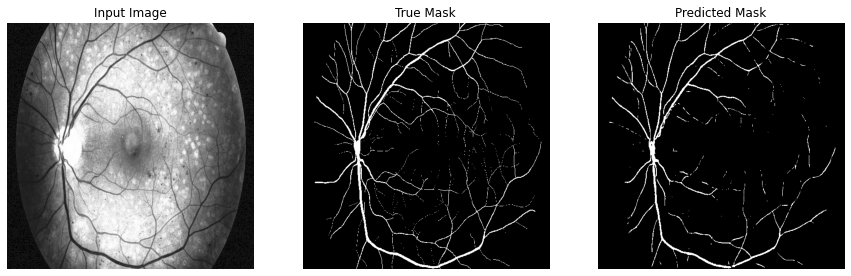


Sample Prediction after epoch 171

3/3 [==============================] - 74s 25s/step - loss: 0.0897 - recall: 0.7479 - accuracy: 0.9781
Epoch 172/200
3/3 [==============================] - 68s 22s/step - loss: 0.0900 - recall: 0.7470 - accuracy: 0.9778
Epoch 173/200
3/3 [==============================] - 68s 21s/step - loss: 0.0887 - recall: 0.7498 - accuracy: 0.9785
Epoch 174/200
3/3 [==============================] - 66s 21s/step - loss: 0.0887 - recall: 0.7491 - accuracy: 0.9783
Epoch 175/200
3/3 [==============================] - 67s 21s/step - loss: 0.0880 - recall: 0.7505 - accuracy: 0.9786
Epoch 176/200
1/1 [==============================] - 5s 5s/steploss: 0.0876 - recall: 0.7509 - accuracy: 0.978


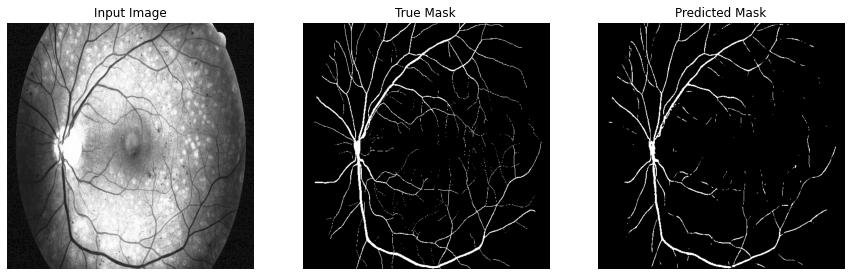


Sample Prediction after epoch 176

3/3 [==============================] - 74s 25s/step - loss: 0.0876 - recall: 0.7509 - accuracy: 0.9787
Epoch 177/200
3/3 [==============================] - 68s 22s/step - loss: 0.0876 - recall: 0.7502 - accuracy: 0.9785
Epoch 178/200
3/3 [==============================] - 67s 21s/step - loss: 0.0869 - recall: 0.7520 - accuracy: 0.9788
Epoch 179/200
3/3 [==============================] - 67s 21s/step - loss: 0.0866 - recall: 0.7526 - accuracy: 0.9788
Epoch 180/200
3/3 [==============================] - 67s 21s/step - loss: 0.0864 - recall: 0.7520 - accuracy: 0.9788
Epoch 181/200
1/1 [==============================] - 6s 6s/steploss: 0.0859 - recall: 0.7522 - accuracy: 0.978


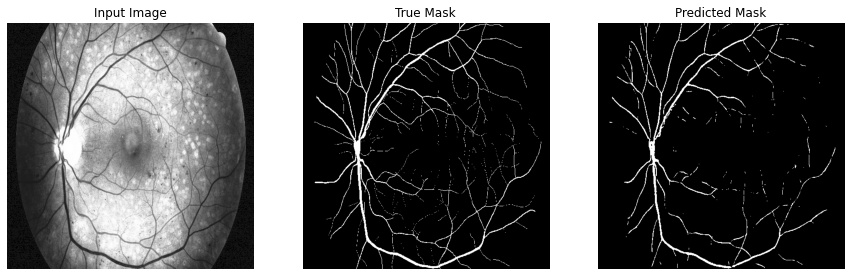


Sample Prediction after epoch 181

3/3 [==============================] - 75s 25s/step - loss: 0.0859 - recall: 0.7522 - accuracy: 0.9789
Epoch 182/200
3/3 [==============================] - 67s 21s/step - loss: 0.0854 - recall: 0.7546 - accuracy: 0.9791
Epoch 183/200
3/3 [==============================] - 67s 21s/step - loss: 0.0855 - recall: 0.7526 - accuracy: 0.9788
Epoch 184/200
3/3 [==============================] - 66s 21s/step - loss: 0.0845 - recall: 0.7558 - accuracy: 0.9794
Epoch 185/200
3/3 [==============================] - 67s 21s/step - loss: 0.0840 - recall: 0.7563 - accuracy: 0.9795
Epoch 186/200
1/1 [==============================] - 5s 5s/steploss: 0.0842 - recall: 0.7553 - accuracy: 0.979


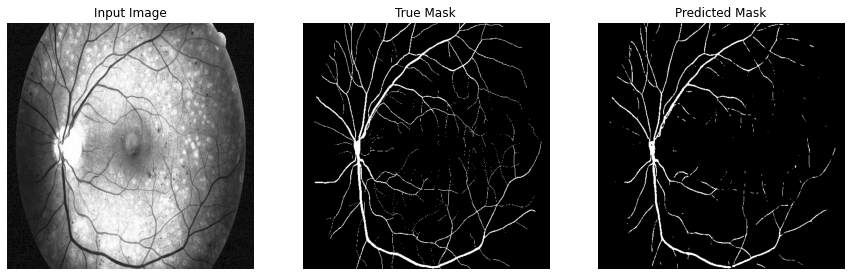


Sample Prediction after epoch 186

3/3 [==============================] - 74s 24s/step - loss: 0.0842 - recall: 0.7553 - accuracy: 0.9792
Epoch 187/200
3/3 [==============================] - 67s 21s/step - loss: 0.0839 - recall: 0.7551 - accuracy: 0.9793
Epoch 188/200
3/3 [==============================] - 67s 21s/step - loss: 0.0838 - recall: 0.7557 - accuracy: 0.9792
Epoch 189/200
3/3 [==============================] - 67s 21s/step - loss: 0.0829 - recall: 0.7577 - accuracy: 0.9796
Epoch 190/200
3/3 [==============================] - 68s 21s/step - loss: 0.0828 - recall: 0.7573 - accuracy: 0.9795
Epoch 191/200
1/1 [==============================] - 5s 5s/steploss: 0.0819 - recall: 0.7582 - accuracy: 0.979


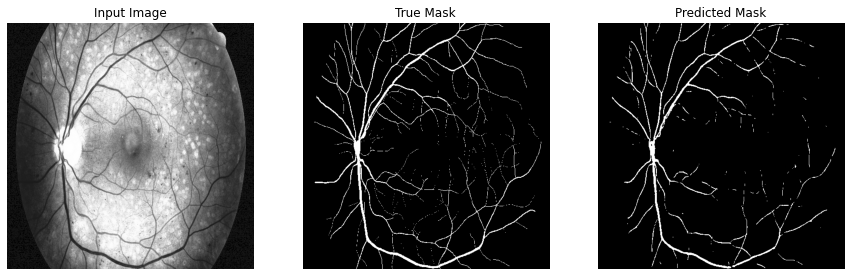


Sample Prediction after epoch 191

3/3 [==============================] - 73s 24s/step - loss: 0.0819 - recall: 0.7582 - accuracy: 0.9799
Epoch 192/200
3/3 [==============================] - 67s 21s/step - loss: 0.0821 - recall: 0.7595 - accuracy: 0.9797
Epoch 193/200
3/3 [==============================] - 67s 21s/step - loss: 0.0818 - recall: 0.7586 - accuracy: 0.9797
Epoch 194/200
3/3 [==============================] - 67s 21s/step - loss: 0.0814 - recall: 0.7588 - accuracy: 0.9798
Epoch 195/200
3/3 [==============================] - 66s 21s/step - loss: 0.0818 - recall: 0.7581 - accuracy: 0.9796
Epoch 196/200
1/1 [==============================] - 5s 5s/steploss: 0.0810 - recall: 0.7597 - accuracy: 0.979


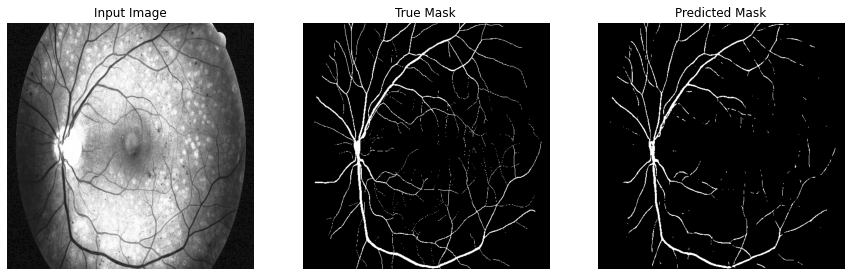


Sample Prediction after epoch 196

3/3 [==============================] - 74s 24s/step - loss: 0.0810 - recall: 0.7597 - accuracy: 0.9799
Epoch 197/200
3/3 [==============================] - 67s 21s/step - loss: 0.0802 - recall: 0.7621 - accuracy: 0.9802
Epoch 198/200
3/3 [==============================] - 67s 21s/step - loss: 0.0800 - recall: 0.7612 - accuracy: 0.9802
Epoch 199/200
3/3 [==============================] - 67s 21s/step - loss: 0.0799 - recall: 0.7616 - accuracy: 0.9801
Epoch 200/200
3/3 [==============================] - 67s 21s/step - loss: 0.0795 - recall: 0.7613 - accuracy: 0.9803


In [20]:
model.fit(
    train_dataset, 
    callbacks=[DisplayCallback(train_dataset)],
    epochs=200
)

# Zdolności predykcyjne nauczonej sieci neuronowej zweryfikowane na zbiorze testowym

Przygotowanie ścieżek do plików testowych

In [21]:
test = 'test'
input_data = os.path.join('edited2', test, 'images')
test_images = sorted(
    [
        os.path.join(input_data, fname)
        for fname in os.listdir(input_data)
    ]
)

input_data = os.path.join(test, 'manual1')
test_manual = sorted(
    [
        os.path.join(input_data, fname)
        for fname in os.listdir(input_data)
    ]
)

Predykcja obrazów ze zbioru testowego

In [22]:
test_dataset = data_generator(test_images, test_manual)
test_dataset_predict = model.predict(
    test_dataset,
    callbacks=[DisplayCallback(test_dataset)],
)

1/1 [==============================] - 5s 5s/step


Obliczenie metryk modelu

In [23]:
model.evaluate(test_dataset, verbose=2)

1/1 - 5s - loss: 0.1231 - recall: 0.5978 - accuracy: 0.9619 - 5s/epoch - 5s/step


[0.12310144305229187, 0.5978270769119263, 0.9618542790412903]

Wyświetlenie i zapisanie predykcji obrazów

In [65]:
for i, prediction in enumerate(test_dataset_predict):
    new_path = 'analize/' + test_images[i]
    print(new_path)
    final_prediction = prediction.copy()
    limit = 0.2
    mask1 = final_prediction > limit
    mask0 = final_prediction <= limit
    final_prediction[mask1] = 255
    final_prediction[mask0] = 0
    
    print(cv2.imwrite(new_path, final_prediction))

analize/edited2\test\images\13_dr.JPG
True
analize/edited2\test\images\13_g.jpg
True
analize/edited2\test\images\13_h.jpg
True
analize/edited2\test\images\14_dr.JPG
True
analize/edited2\test\images\14_g.jpg
True
analize/edited2\test\images\14_h.jpg
True
analize/edited2\test\images\15_dr.JPG
True
analize/edited2\test\images\15_g.jpg
True
analize/edited2\test\images\15_h.jpg
True


# Skuteczność algorytmu

In [25]:
prediction = test_dataset_predict[0]

Przygotowanie przykładowego obrazu do oceny

In [26]:
final_image = final_prediction.copy()
limit = 128
mask = final_image > limit
mask0 = final_image <= limit
final_image[mask] = 255
final_image[mask0] = 0

Wczytanie nazwy analizowanego pliku

In [27]:
image_name = test_images[0]

Wczytanie pliku zawierąjacego obraz z ręcznie zaznaczonymi naczyniami

In [28]:
manual_image_path = test_manual[0]
manual_image = cv2.imread(manual_image_path)

Zamiana obrazu na skalę szarości

In [29]:
gray_manual_image = cv2.cvtColor(manual_image, cv2.COLOR_BGR2GRAY)

Zmiana rozmiaru obrazu

In [30]:
resized_image = cv2.resize(gray_manual_image, (image_size, image_size))

Wyświetlenie wynikowego i eksperckiego obrazu

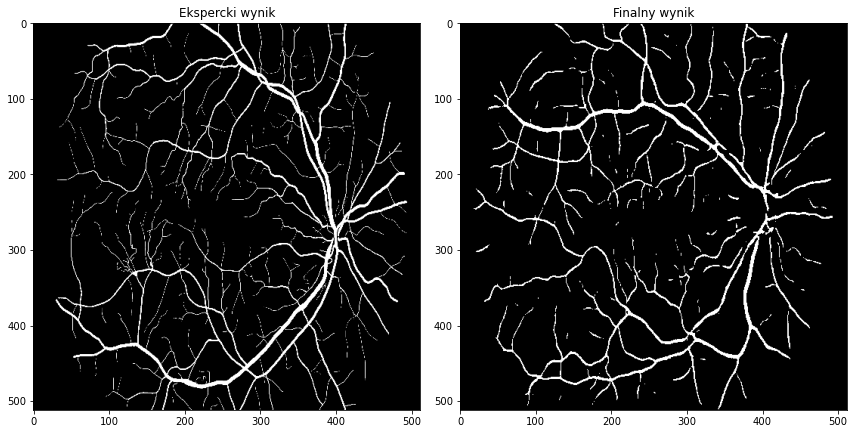

In [31]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2), plt.imshow(final_image, cmap='gray'), plt.title('Finalny wynik')
plt.subplot(1, 2, 1), plt.imshow(resized_image, cmap='gray'), plt.title('Ekspercki wynik')

plt.tight_layout()
plt.show()

Wygenerowanie binarnej, eksperckiej maski

In [32]:
correct_mask = resized_image > 0

Przypisanie wymiarów maski do zmiennych

In [33]:
mask_height, mask_width = resized_image.shape

Obliczenie macierzy pomyłek

In [34]:
true_positive = 0
false_positive = 0
false_negative = 0
true_negative = 0

for i in range(mask_height):
    for j in range(mask_width):
        if mask[i][j] == True and correct_mask[i][j] == True:
            true_positive += 1
        elif mask[i][j] == True and correct_mask[i][j] == False:
            false_positive += 1
        elif mask[i][j] == False and correct_mask[i][j] == True:
            false_negative += 1
        elif mask[i][j] == False and correct_mask[i][j] == False:
            true_negative += 1

Wyświetlenie macierzy pomyłek

In [35]:
print(true_positive, false_negative, false_positive, true_negative)

2024 18720 15255 226145


Wizualizacja macierzy pomyłek

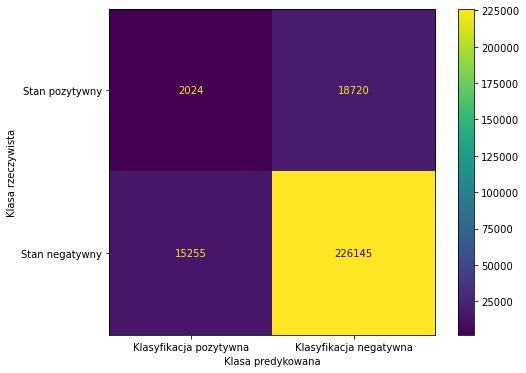

In [36]:
cm = np.array([[true_positive, false_negative], [false_positive, true_negative]])

# Tworzenie obiektu ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Definiowanie nowych etykiet dla osi
x_labels = ['Klasyfikacja pozytywna', 'Klasyfikacja negatywna']
y_labels = ['Stan pozytywny', 'Stan negatywny']

# Wyświetlanie wizualizacji macierzy pomyłek
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax)

# Modyfikowanie etykiet na osiach
ax.set_xticklabels(x_labels)
ax.set_yticklabels(y_labels)

# Modyfikowanie nagłówków dla osi x i y
ax.set_xlabel("Klasa predykowana")
ax.set_ylabel("Klasa rzeczywista")

# Wyświetlanie wizualizacji
plt.show()

Trafność

In [37]:
accuracy = (true_positive + true_negative)/(true_positive + false_positive + false_negative + true_negative)
accuracy

0.8703956604003906

Czułość

In [38]:
sensitivity = (true_positive)/(true_positive + false_negative)
sensitivity

0.09757038179714617

Swoistość

In [39]:
specificity = (true_negative)/(false_positive + true_negative)
specificity

0.9368061309030654

Średnia arytmetyczna czułości i swoistości

In [40]:
(sensitivity + specificity)/2

0.5171882563501058